In [1]:
import pandas as pd

In [2]:
pip install pyedflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 9.0 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import numpy as np

def read_eea_file(eea_file):
    with open(eea_file, 'r') as f:
        data = f.read().split('\n')
    data = [float(item) for item in data if item]  # convert to float and remove empty strings
    return np.array(data)

def read_all_eea_files(directory, label):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".eea"):
            data = read_eea_file(os.path.join(directory, filename))
            all_data.append(data)
    return all_data, np.full((len(all_data),), label)

directories = [
    ("/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-Normal", 0), 
    ("/kaggle/input/mhrc-dataset-data/SCZ-Dataset2-SCZ", 1)
]

all_data_list = []
labels_list = []
for directory, label in directories:
    data, y = read_all_eea_files(directory, label)
    all_data_list.extend(data)
    labels_list.extend(y)

all_data = np.array(all_data_list)
labels1 = np.array(labels_list)


In [4]:
import os
import numpy as np
from scipy.signal import welch
from scipy.stats import entropy

def compute_psd(signal, fs=128, nperseg=256):
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    return freqs, psd

def compute_se(psd, freqs, bands):
    se = []
    for band in bands:
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd[band_mask]
        band_psd /= np.sum(band_psd)
        se.append(entropy(band_psd))
    return se

def compute_de(psd, freqs, bands):
    de = []
    for band in bands:
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd[band_mask]
        band_de = np.sum(np.log(band_psd + 1e-10) * band_psd)
        de.append(band_de)
    return de

def extract_features(signal, fs=128, bands=None):
    freqs, psd = compute_psd(signal, fs)
    if bands is None:
        bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
    psd_features = np.array([np.trapz(psd[(freqs >= b[0]) & (freqs <= b[1])]) for b in bands])
    se = compute_se(psd, freqs, bands)
    de = compute_de(psd, freqs, bands)
    return psd_features, se, de

def read_eea_file(eea_file, num_channels=16, samples_per_channel=7680):
    with open(eea_file, 'r') as f:
        data = f.read().split('\n')
    data = [float(item) for item in data if item]
    return np.reshape(data, (num_channels, samples_per_channel))

def create_brain_map_per_band(data, channels, position_map):
    brain_maps = []
    for band_data in data:
        brain_map = np.zeros((8, 9))
        for ch in channels:
            if ch in position_map:
                pos = position_map[ch]
                x, y = map(int, pos.split(','))
                brain_map[x, y] = band_data[channels.index(ch)]
        brain_maps.append(brain_map)
    return np.array(brain_maps)

def process_eea_and_store_brain_maps(directory, channels, position_map):
    all_psd_maps = []
    all_se_maps = []
    all_de_maps = []
    labels = []
    bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
    
    for subdir, label in [('SCZ-Dataset2-Normal', 0), ('SCZ-Dataset2-SCZ', 1)]:
        subdir_path = os.path.join(directory, subdir)
        for filename in os.listdir(subdir_path):
            if filename.endswith(".eea"):
                file_path = os.path.join(subdir_path, filename)
                data_array = read_eea_file(file_path)
                
                psd_brain_maps_per_band = []
                se_brain_maps_per_band = []
                de_brain_maps_per_band = []
                
                for ch in range(data_array.shape[0]):
                    psd, se, de = extract_features(data_array[ch, :])
                    
                    psd_brain_maps_per_band.append(psd)
                    se_brain_maps_per_band.append(se)
                    de_brain_maps_per_band.append(de)
                
                psd_maps = create_brain_map_per_band(np.transpose(psd_brain_maps_per_band), channels, position_map)
                se_maps = create_brain_map_per_band(np.transpose(se_brain_maps_per_band), channels, position_map)
                de_maps = create_brain_map_per_band(np.transpose(de_brain_maps_per_band), channels, position_map)
                
                all_psd_maps.append(psd_maps)
                all_se_maps.append(se_maps)
                all_de_maps.append(de_maps)
                labels.append(label)
    
    return (np.array(all_psd_maps), np.array(all_se_maps), np.array(all_de_maps)), np.array(labels)

channels = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
position_map = {
    'F7': '1,0', 'F3': '1,2', 'F4': '1,6', 'F8': '1,8', 
    'T3': '3,0', 'C3': '3,2', 'Cz': '3,4', 'C4': '3,6', 'T4': '3,8', 
    'T5': '5,0', 'P3': '5,2', 'Pz': '5,4', 'P4': '5,6', 'T6': '5,8', 
    'O1': '7,3', 'O2': '7,5'
}

directory = "/kaggle/input/mhrc-dataset-data"
(all_psd_maps, all_se_maps, all_de_maps), labels_eea = process_eea_and_store_brain_maps(directory, channels, position_map)

print(all_psd_maps.shape)
print(all_se_maps.shape)
print(all_de_maps.shape)
print(labels_eea.shape)


(84, 4, 8, 9)
(84, 4, 8, 9)
(84, 4, 8, 9)
(84,)


In [5]:
all_de_maps.max()

33927600.50604353

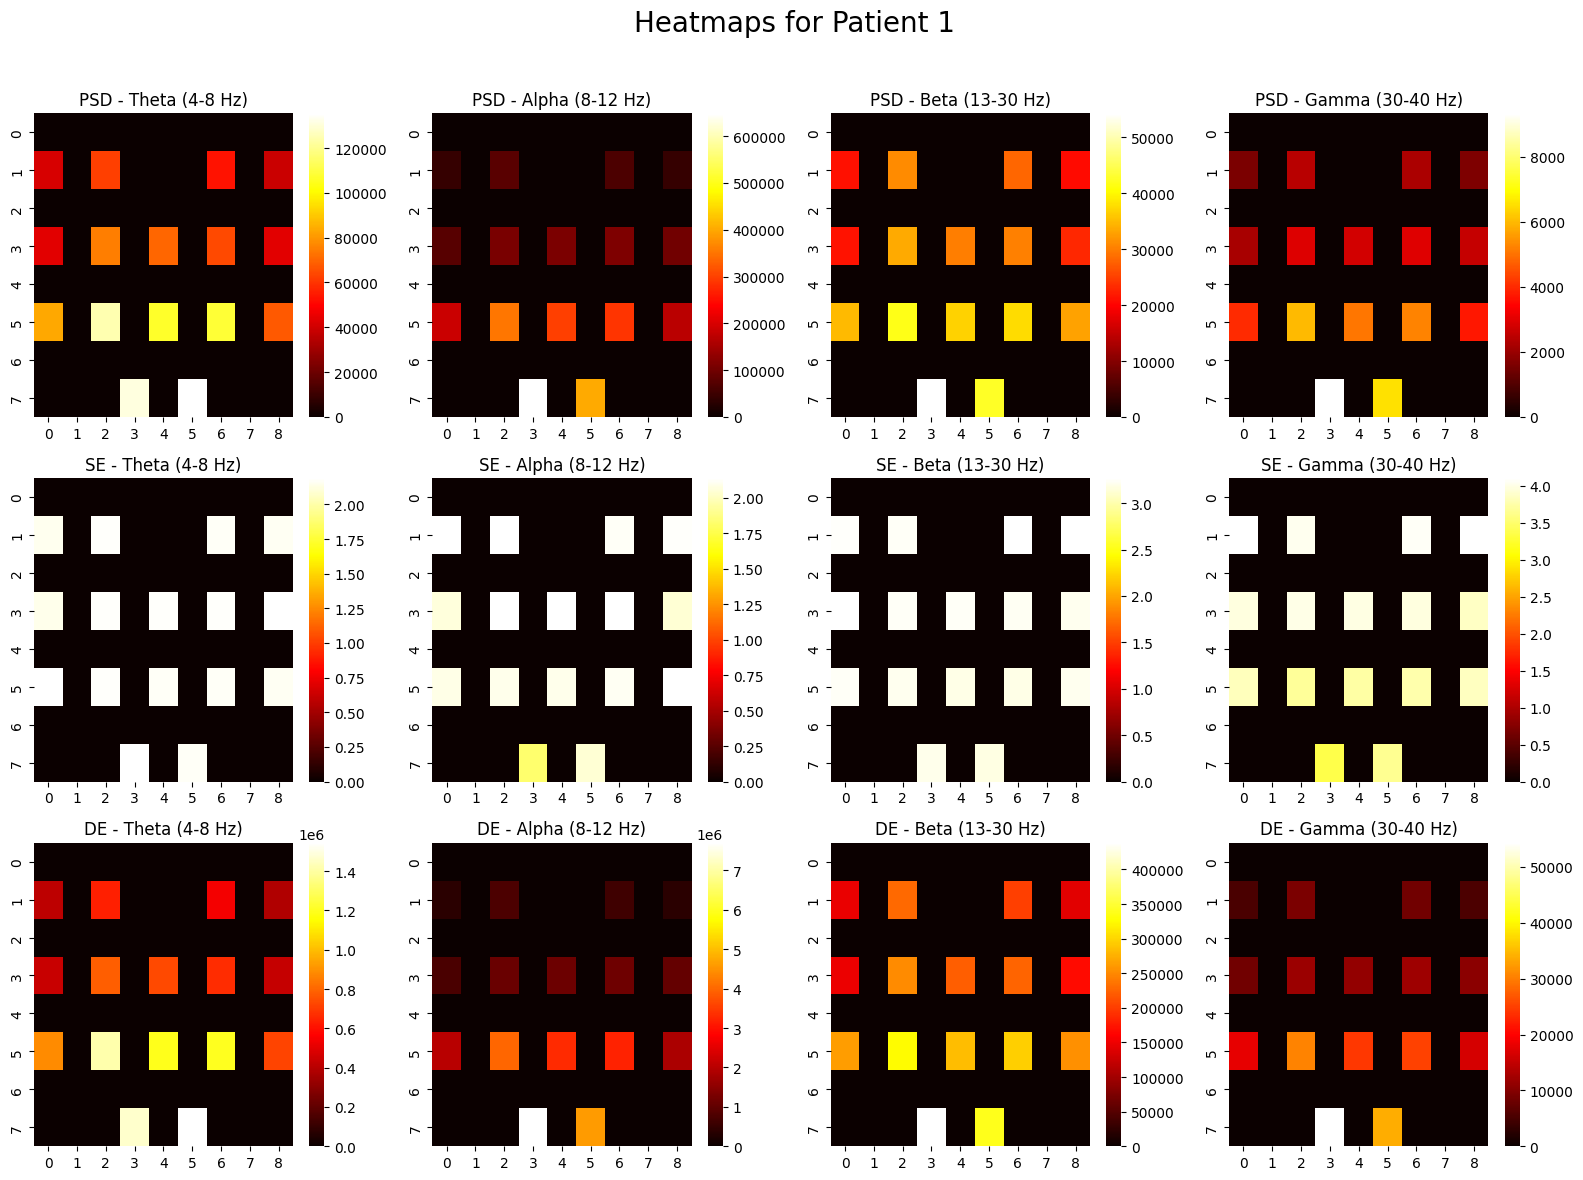

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_brain_map_heatmaps(patient_index, all_psd_maps, all_se_maps, all_de_maps, bands):
    band_names = ['Theta (4-8 Hz)', 'Alpha (8-12 Hz)', 'Beta (13-30 Hz)', 'Gamma (30-40 Hz)']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'Heatmaps for Patient {patient_index + 1}', fontsize=20)
    
    for i, band in enumerate(bands):
        sns.heatmap(all_psd_maps[patient_index, i], ax=axes[0, i], cmap='hot', cbar=True)
        axes[0, i].set_title(f'PSD - {band_names[i]}')
    
    for i, band in enumerate(bands):
        sns.heatmap(all_se_maps[patient_index, i], ax=axes[1, i], cmap='hot', cbar=True)
        axes[1, i].set_title(f'SE - {band_names[i]}')
    
    for i, band in enumerate(bands):
        sns.heatmap(all_de_maps[patient_index, i], ax=axes[2, i], cmap='hot', cbar=True)
        axes[2, i].set_title(f'DE - {band_names[i]}')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
patient_index = 0

plot_brain_map_heatmaps(patient_index, all_psd_maps, all_se_maps, all_de_maps, bands)


In [8]:
all_de_maps.shape

(84, 4, 8, 9)

In [9]:
import os
import pyedflib
import numpy as np
import pandas as pd
from scipy.signal import welch
from scipy.stats import entropy

def compute_psd(signal, fs=256, nperseg=256):
    freqs, psd = welch(signal, fs=fs, nperseg=nperseg)
    return freqs, psd

def compute_se(psd, freqs, bands):
    se = []
    for band in bands:
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd[band_mask]
        band_psd /= np.sum(band_psd)
        se.append(entropy(band_psd))
    return se

def compute_de(psd, freqs, bands):
    de = []
    for band in bands:
        band_mask = (freqs >= band[0]) & (freqs <= band[1])
        band_psd = psd[band_mask]
        band_de = np.sum(np.log(band_psd + 1e-10) * band_psd)
        de.append(band_de)
    return de

def extract_features(signal, fs=256, bands=None):
    freqs, psd = compute_psd(signal, fs)
    if bands is None:
        bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
    psd_features = np.array([np.trapz(psd[(freqs >= b[0]) & (freqs <= b[1])]) for b in bands])
    se = compute_se(psd, freqs, bands)
    de = compute_de(psd, freqs, bands)
    return psd_features, se, de

def read_edf(edf_file):
    f = pyedflib.EdfReader(edf_file)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    df = pd.DataFrame(sigbufs.transpose(), columns=signal_labels)
    df = df.drop(columns=['Fp1', 'Fz', 'Fp2'])
    return df

def create_brain_map_per_band(data, channels, position_map):
    brain_maps = []
    for band_data in data:
        brain_map = np.zeros((8, 9))
        for ch in channels:
            if ch in position_map:
                pos = position_map[ch]
                x, y = map(int, pos.split(','))
                brain_map[x, y] = band_data[channels.index(ch)]
        brain_maps.append(brain_map)
    return np.array(brain_maps)

def process_and_store_brain_maps(directory, channels, position_map):
    all_psd_maps = []
    all_se_maps = []
    all_de_maps = []
    labels = []
    bands = [(4, 8), (8, 12), (13, 30), (30, 100)]
    
    for filename in os.listdir(directory):
        if filename.endswith(".edf"):
            if filename.startswith("h"):
                label = 0
            elif filename.startswith("s"):
                label = 1
            else:
                continue
            
            df = read_edf(os.path.join(directory, filename))
            data_array = df[channels].values
            
            psd_brain_maps_per_band = []
            se_brain_maps_per_band = []
            de_brain_maps_per_band = []
            
            for ch in range(data_array.shape[1]):
                psd, se, de = extract_features(data_array[:, ch])
                
                psd_brain_maps_per_band.append(psd)
                se_brain_maps_per_band.append(se)
                de_brain_maps_per_band.append(de)
            
            psd_maps = create_brain_map_per_band(np.transpose(psd_brain_maps_per_band), channels, position_map)
            se_maps = create_brain_map_per_band(np.transpose(se_brain_maps_per_band), channels, position_map)
            de_maps = create_brain_map_per_band(np.transpose(de_brain_maps_per_band), channels, position_map)
            
            all_psd_maps.append(psd_maps)
            all_se_maps.append(se_maps)
            all_de_maps.append(de_maps)
            labels.append(label)
    
    return (np.array(all_psd_maps), np.array(all_se_maps), np.array(all_de_maps)), np.array(labels)

channels = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'O1', 'O2']
position_map = {
    'F7': '1,0', 'F3': '1,2', 'F4': '1,6', 'F8': '1,8', 
    'T3': '3,0', 'C3': '3,2', 'Cz': '3,4', 'C4': '3,6', 'T4': '3,8', 
    'T5': '5,0', 'P3': '5,2', 'Pz': '5,4', 'P4': '5,6', 'T6': '5,8', 
    'O1': '7,3', 'O2': '7,5'
}

directory = "/kaggle/input/schizophrenia"

(all_psd_maps_edf, all_se_maps_edf, all_de_maps_edf), labels_edf = process_and_store_brain_maps(directory, channels, position_map)

print(all_psd_maps_edf.shape)
print(all_se_maps_edf.shape)
print(all_de_maps_edf.shape)
print(labels_edf.shape)


(28, 4, 8, 9)
(28, 4, 8, 9)
(28, 4, 8, 9)
(28,)


In [10]:
import numpy as np


merged_psd_maps = np.concatenate([all_psd_maps_edf, all_psd_maps], axis=0)


merged_se_maps = np.concatenate([all_se_maps_edf, all_se_maps], axis=0)


merged_de_maps = np.concatenate([all_de_maps_edf, all_de_maps], axis=0)


print(f"Merged PSD Maps Shape: {merged_psd_maps.shape}")  
print(f"Merged SE Maps Shape: {merged_se_maps.shape}")    
print(f"Merged DE Maps Shape: {merged_de_maps.shape}")    


Merged PSD Maps Shape: (112, 4, 8, 9)
Merged SE Maps Shape: (112, 4, 8, 9)
Merged DE Maps Shape: (112, 4, 8, 9)


In [11]:
merged_labels = np.concatenate([labels_eea,labels_edf],axis=0)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

output_dir = '/kaggle/working/merged_brain_maps'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

def save_brain_maps_and_labels(psd_maps, se_maps, de_maps, labels, bands, output_dir, dpi=150):
    num_patients = psd_maps.shape[0]
    num_bands = len(bands)

    label_file = open(os.path.join(output_dir, "labels.csv"), "w")
    label_file.write("Patient_ID,Label\n")

    for patient_idx in range(num_patients):
        patient_dir = os.path.join(output_dir, f'patient_{patient_idx+1}')
        if not os.path.exists(patient_dir):
            os.makedirs(patient_dir)

        label = labels[patient_idx]
        label_file.write(f'patient_{patient_idx+1},{label}\n')

        for i, feature_maps in enumerate([psd_maps[patient_idx], se_maps[patient_idx], de_maps[patient_idx]]):
            for j in range(num_bands):
                plt.figure(figsize=(6, 6), dpi=dpi)
                brain_map = feature_maps[j]

                norm_map = (brain_map - np.min(brain_map)) / (np.max(brain_map) - np.min(brain_map))

                sns.heatmap(norm_map, cmap='hot', cbar=False, annot=False, fmt=".2f", 
                            linewidths=0.1, linecolor='black', square=True)

                plt.contour(norm_map, levels=np.linspace(0, 1, 10), colors='black', linewidths=0.5)

                plt.axis('off')

                feature_name = ['PSD', 'SE', 'DE'][i]
                band_name = f"{bands[j][0]}-{bands[j][1]}Hz"
                file_name = f"{patient_dir}/{feature_name}_Band_{band_name}.png"
                plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
                plt.close()

    label_file.close()

bands = [(4, 8), (8, 12), (13, 30), (30, 100)]

save_brain_maps_and_labels(merged_psd_maps, merged_se_maps, merged_de_maps, merged_labels, bands, output_dir)

print("Improved heatmaps saved successfully, and labels saved to labels.csv!")


Improved heatmaps saved successfully, and labels saved to labels.csv!


/tmp/ipykernel_33/251828201.py:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


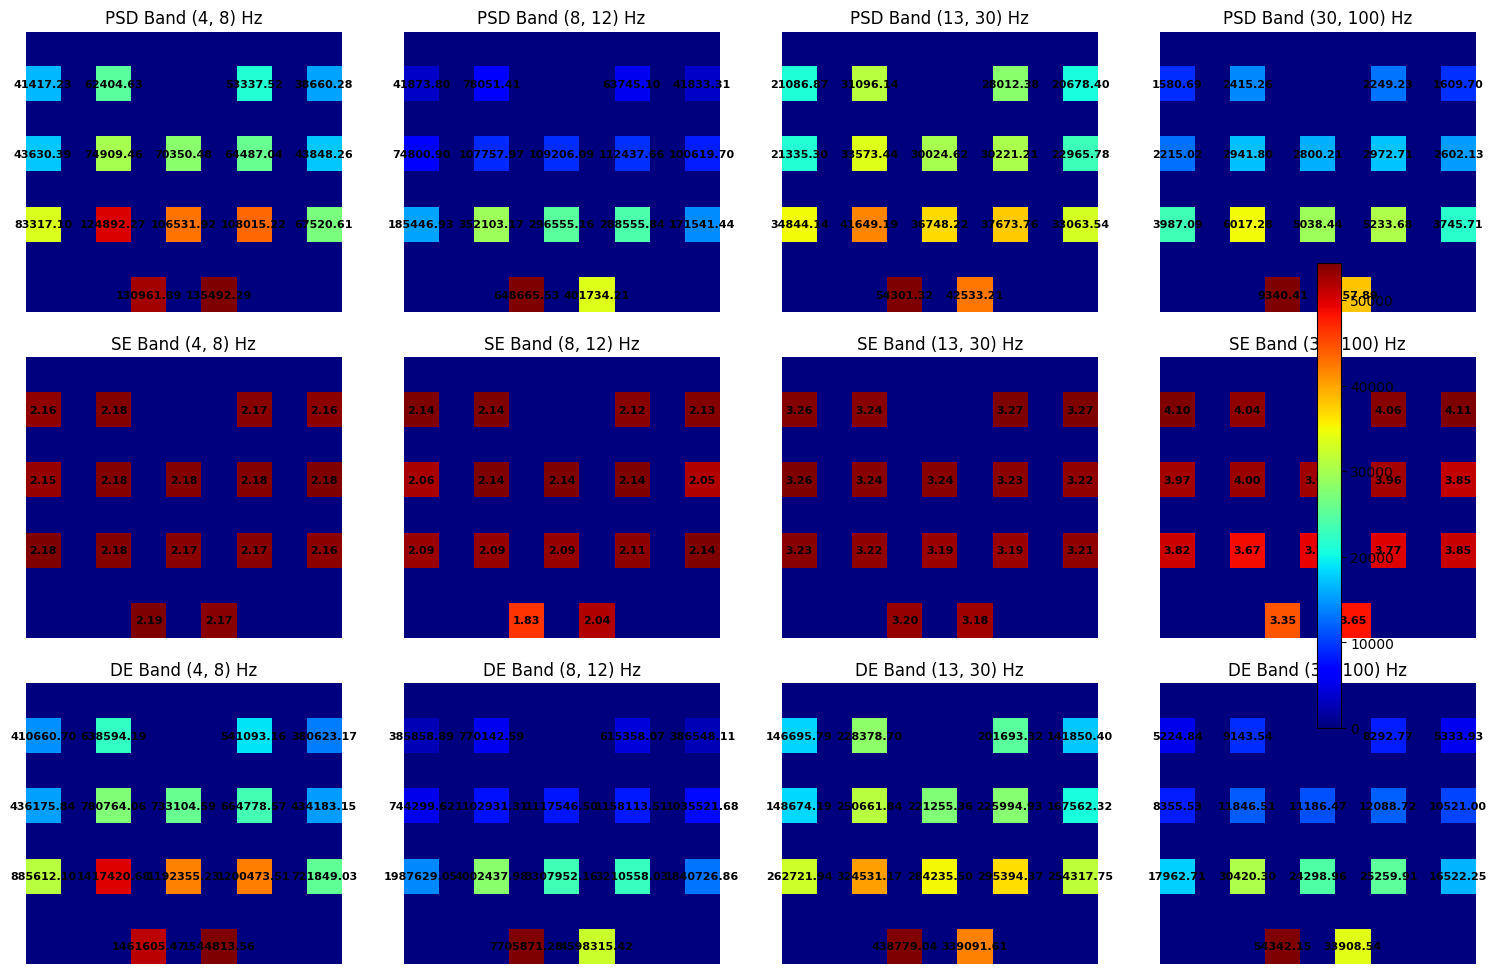

In [13]:
import matplotlib.pyplot as plt

def plot_brain_maps_with_values(psd_maps, se_maps, de_maps, bands, channel_positions):
    num_bands = len(bands)
    
    fig, axes = plt.subplots(3, num_bands, figsize=(15, 10), sharex=True, sharey=True)
    
    feature_titles = ['PSD', 'SE', 'DE']
    
    for i, feature_maps in enumerate([psd_maps, se_maps, de_maps]):
        for j in range(num_bands):
            ax = axes[i, j]
            brain_map = feature_maps[j]
            cax = ax.imshow(brain_map, cmap='jet', interpolation='nearest')
            ax.set_title(f'{feature_titles[i]} Band {bands[j]} Hz')
            ax.axis('off')
            
            for (x, y), value in np.ndenumerate(brain_map):
                if value != 0:
                    ax.text(y, x, f'{value:.2f}', ha='center', va='center', fontsize=8, color='black', weight='bold')

    fig.colorbar(cax, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    
    plt.tight_layout()
    plt.show()

patient_index = 0
bands = [(4, 8), (8, 12), (13, 30), (30, 100)]

patient_psd_maps = all_psd_maps[patient_index]
patient_se_maps = all_se_maps[patient_index]
patient_de_maps = all_de_maps[patient_index]

plot_brain_maps_with_values(patient_psd_maps, patient_se_maps, patient_de_maps, bands, position_map)


In [14]:
channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4', 'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
position_map = {'AF3': '0,2', 'F3': '1,2', 'Fp1': '0,3', 'Fp2': '0,5', 'AF4': '0,6', 'F4': '1,6', 'F7': '1,0', 'Fz': '1,4', 'F8': '1,8', 
                'FC5': '2,1', 'FC1': '2,3', 'FC2': '2,5', 'FC6': '2,7', 'CP5': '4,1', 'CP1': '4,3', 'CP2': '4,5', 'Cz': '3,4', 
                'C4': '3,6', 'T4': '3,8', 'CP6': '4,7', 'P7': '5,0', 'P3': '5,2', 'Pz': '5,4', 'P4': '5,6', 'P8': '5,8', 
                'T3': '3,0', 'C3': '3,2', 'PO3': '6,5', 'PO4': '6,3', 'O1': '7,3', 'Oz': '7,4', 'O2': '7,5'}

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def build_cnn_lstm_model(input_shape=(4, 9, 8, 1)):
    cnn_model = models.Sequential()
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Flatten()))
    cnn_model.add(layers.LSTM(128, return_sequences=False))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(512, activation='relu'))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(2, activation='softmax'))
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

cnn_lstm_model = build_cnn_lstm_model(input_shape=(4, 9, 8, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

def train_on_feature(cnn_lstm_model, feature_maps, labels, feature_name):
    x_train, x_val, y_train, y_val = train_test_split(feature_maps, labels, test_size=0.2, random_state=42)
    
    history = cnn_lstm_model.fit(
        x_train, y_train,
        epochs=100,
        batch_size=16,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )
    
    return history
labels = to_categorical(merged_labels, num_classes=2)

print("Training on PSD maps...")
history_psd = train_on_feature(cnn_lstm_model, merged_psd_maps, labels, 'PSD')

print("Training on DE maps...")
history_de = train_on_feature(cnn_lstm_model, merged_de_maps, labels, 'DE')

print("Training on SE maps...")
history_se = train_on_feature(cnn_lstm_model, merged_se_maps, labels, 'SE')

cnn_lstm_model.save(f'/kaggle/working/cnn_lstm_model.h5')


Training on PSD maps...
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step - accuracy: 0.5389 - loss: 0.7246 - val_accuracy: 0.8696 - val_loss: 0.4532 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7406 - loss: 0.4983 - val_accuracy: 0.8696 - val_loss: 0.4186 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7530 - loss: 0.4731 - val_accuracy: 0.6522 - val_loss: 0.4967 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7593 - loss: 0.4756 - val_accuracy: 0.6087 - val_loss: 0.5781 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7421 - loss: 0.4561 - val_accuracy: 0.4783 - val_loss: 0.7321 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6736 - loss: 0.5551 - val_accuracy: 0.4783 - val_loss: 0.8032 - learning_rate: 5.0000e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8008 - 

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

def stack_brain_maps(psd_maps, de_maps, se_maps):
    stacked_maps = np.concatenate([psd_maps, de_maps, se_maps], axis=1)
    return stacked_maps

def build_stacked_cnn_model(input_shape=(12, 8, 9), num_classes=2):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, (4, 4), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, (4, 4), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, (2, 2), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, brain_maps, labels, epochs=100, batch_size=5):
    from sklearn.model_selection import train_test_split
    x_train, x_val, y_train, y_val = train_test_split(brain_maps, labels, test_size=0.2, random_state=42)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=10, min_lr=1e-6, verbose=1)
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val), callbacks=[early_stopping,reduce_lr])
    return history

stacked_brain_maps = stack_brain_maps(merged_psd_maps, merged_de_maps, merged_se_maps)
num_classes = len(np.unique(labels))


print("Training on stacked brain maps (PSD, DE, SE)...")
model_stacked = build_stacked_cnn_model(input_shape=(12, 8, 9), num_classes=2)
history_stacked = train_model(model_stacked, stacked_brain_maps, labels)


Training on stacked brain maps (PSD, DE, SE)...
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.4461 - loss: 1.4882 - val_accuracy: 0.7826 - val_loss: 0.5372 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7605 - loss: 0.8352 - val_accuracy: 0.8696 - val_loss: 0.4973 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4805 - loss: 1.3368 - val_accuracy: 0.7391 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6947 - loss: 0.5834 - val_accuracy: 0.7826 - val_loss: 0.5221 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7072 - loss: 0.9523 - val_accuracy: 0.5652 - val_loss: 1.7287 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7234 - loss: 0.6337 - val_accuracy: 0.4348 - val_loss: 3.1189 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1

In [26]:
pip install antropy

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.7 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16875 sha256=2df89a2c3b2aa24f258a194e653cc9e5f1dce37c499ea544306ed9c3dbe2117e
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy
Note: you may need to restart the kernel to use updated packages.


In [32]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_brain_maps_by_feature(feature_type, bands, img_size=(8, 9), data_dir='/kaggle/working/merged_brain_maps', labels_dict=None):
    feature_maps = []
    patient_labels = []
    
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        
        if os.path.isdir(patient_path):
            patient_maps = []
            
            for band_range in bands:
                band_filename = f"{feature_type}_Band_{band_range[0]}-{band_range[1]}Hz.png"
                band_path = os.path.join(patient_path, band_filename)
                
                if os.path.exists(band_path):
                    img = cv2.imread(band_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, img_size)
                    img_array = img_to_array(img)
                    patient_maps.append(img_array)
                else:
                    print(f"Missing map: {band_path}")
            
            if len(patient_maps) == len(bands):
                feature_maps.append(np.stack(patient_maps))
                patient_id = patient_dir
                if patient_id in labels_dict:
                    patient_labels.append(labels_dict[patient_id])
                else:
                    print(f"Label missing for patient ID: {patient_id}")
    
    feature_maps = np.array(feature_maps)
    patient_labels = np.array(patient_labels)
    
    return feature_maps, patient_labels

bands = [(4, 8), (8, 12), (13, 30), (30, 100)]

labels_df = pd.read_csv('/kaggle/working/merged_brain_maps/labels.csv')
labels_dict = pd.Series(labels_df.Label.values, index=labels_df.Patient_ID).to_dict()

psd_maps, labels_psd = load_brain_maps_by_feature('PSD', bands, labels_dict=labels_dict)
de_maps, labels_de = load_brain_maps_by_feature('DE', bands, labels_dict=labels_dict)
se_maps, labels_se = load_brain_maps_by_feature('SE', bands, labels_dict=labels_dict)

labels_psd = tf.keras.utils.to_categorical(labels_psd)
labels_de = tf.keras.utils.to_categorical(labels_de)
labels_se = tf.keras.utils.to_categorical(labels_se)

def build_cnn_lstm_model(input_shape=(4, 9, 8, 1)):
    cnn_model = models.Sequential()
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Flatten()))
    cnn_model.add(layers.LSTM(128, return_sequences=False))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(512, activation='relu'))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(2, activation='softmax'))
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

cnn_lstm_model = build_cnn_lstm_model(input_shape=(4, 9, 8, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

def train_on_feature(cnn_lstm_model, feature_maps, labels, feature_name):
    x_train, x_val, y_train, y_val = train_test_split(feature_maps, labels, test_size=0.2, random_state=42)
    
    history = cnn_lstm_model.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stopping,reduce_lr])
    
    return history

print("Training on PSD maps...")
print(f"Shape of PSD maps: {psd_maps.shape}, Shape of labels: {labels_psd.shape}")
history_psd = train_on_feature(cnn_lstm_model, psd_maps, labels_psd, 'PSD')

print("Training on DE maps...")
print(f"Shape of DE maps: {de_maps.shape}, Shape of labels: {labels_de.shape}")
history_de = train_on_feature(cnn_lstm_model, de_maps, labels_de, 'DE')

print("Training on SE maps...")
print(f"Shape of SE maps: {se_maps.shape}, Shape of labels: {labels_se.shape}")
history_se = train_on_feature(cnn_lstm_model, se_maps, labels_se, 'SE')

cnn_lstm_model.save(f'/kaggle/working/cnn_lstm_model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on PSD maps...
Shape of PSD maps: (112, 4, 9, 8, 1), Shape of labels: (112, 2)
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - accuracy: 0.4745 - loss: 0.7546 - val_accuracy: 0.6522 - val_loss: 0.5975 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7061 - loss: 0.5407 - val_accuracy: 0.6957 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7755 - loss: 0.4789 - val_accuracy: 0.6522 - val_loss: 0.5909 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6718 - loss: 0.5366 - val_accuracy: 0.7391 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7886 - loss: 0.4369 - val_accuracy: 0.6957 - val_loss: 0.5515 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.7951 - loss: 0.4429 - val_accuracy: 0.5652 - val_loss: 0.6293 - learning_rate: 0.0010
Epoch 7/100

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def load_and_stack_psd_de_maps(bands, img_size=(8, 9), data_dir='/kaggle/working/merged_brain_maps', labels_dict=None):
    feature_maps = []
    patient_labels = []
    
    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        
        if os.path.isdir(patient_path):
            patient_maps = []
            
            for band_range in bands:
                psd_filename = f"PSD_Band_{band_range[0]}-{band_range[1]}Hz.png"
                psd_path = os.path.join(patient_path, psd_filename)
                
                de_filename = f"DE_Band_{band_range[0]}-{band_range[1]}Hz.png"
                de_path = os.path.join(patient_path, de_filename)
                
                if os.path.exists(psd_path) and os.path.exists(de_path):
                    psd_img = cv2.imread(psd_path, cv2.IMREAD_GRAYSCALE)
                    psd_img = cv2.resize(psd_img, img_size)
                    psd_img_array = img_to_array(psd_img)
                    
                    de_img = cv2.imread(de_path, cv2.IMREAD_GRAYSCALE)
                    de_img = cv2.resize(de_img, img_size)
                    de_img_array = img_to_array(de_img)
                    
                    patient_maps.append(psd_img_array)
                    patient_maps.append(de_img_array)
                else:
                    print(f"Missing map: {psd_path} or {de_path}")
            
            if len(patient_maps) == 8:
                feature_maps.append(np.stack(patient_maps))
                
                patient_id = patient_dir
                if patient_id in labels_dict:
                    patient_labels.append(labels_dict[patient_id])
                else:
                    print(f"Label missing for patient ID: {patient_id}")
    
    feature_maps = np.array(feature_maps)
    patient_labels = np.array(patient_labels)
    
    return feature_maps, patient_labels

bands = [(4, 8), (8, 12), (13, 30), (30, 100)]

labels_df = pd.read_csv('/kaggle/working/merged_brain_maps/labels.csv')
labels_dict = pd.Series(labels_df.Label.values, index=labels_df.Patient_ID).to_dict()

stacked_maps, labels_stacked = load_and_stack_psd_de_maps(bands, labels_dict=labels_dict)

labels_stacked = tf.keras.utils.to_categorical(labels_stacked)

def build_cnn_lstm_model(input_shape=(8, 9, 8, 1)):
    cnn_model = models.Sequential()
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu', padding='same')))
    cnn_model.add(layers.TimeDistributed(layers.BatchNormalization()))
    cnn_model.add(layers.TimeDistributed(layers.MaxPooling2D(pool_size=(2, 2))))
    cnn_model.add(layers.TimeDistributed(layers.Flatten()))
    cnn_model.add(layers.LSTM(128, return_sequences=False))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(512, activation='relu'))
    cnn_model.add(layers.Dropout(0.5))
    cnn_model.add(layers.Dense(2, activation='softmax'))
    cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return cnn_model

cnn_lstm_model = build_cnn_lstm_model(input_shape=(8, 9, 8, 1))

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10)

def train_on_stacked_maps(cnn_lstm_model, feature_maps, labels):
    x_train, x_val, y_train, y_val = train_test_split(feature_maps, labels, test_size=0.2, random_state=42)
    
    history = cnn_lstm_model.fit(
        x_train, y_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping,reduce_lr]
    )
    
    return history

print("Training on stacked PSD and DE maps...")
print(f"Shape of stacked maps: {stacked_maps.shape}, Shape of labels: {labels_stacked.shape}")
history_stacked = train_on_stacked_maps(cnn_lstm_model, stacked_maps, labels_stacked)

cnn_lstm_model.save('/kaggle/working/cnn_lstm_stacked_psd_de_model.h5')


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training on stacked PSD and DE maps...
Shape of stacked maps: (112, 8, 9, 8, 1), Shape of labels: (112, 2)
Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 637ms/step - accuracy: 0.5539 - loss: 0.7241 - val_accuracy: 0.7391 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7211 - loss: 0.5407 - val_accuracy: 0.7391 - val_loss: 0.5919 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.7250 - loss: 0.5403 - val_accuracy: 0.6957 - val_loss: 0.6172 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6674 - loss: 0.5544 - val_accuracy: 0.7826 - val_loss: 0.5399 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.7692 - loss: 0.4512 - val_accuracy: 0.7826 - val_loss: 0.5021 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7453 - loss: 0.5224 - val_accuracy: 0.7826 - val_loss: 0.5182 - learning

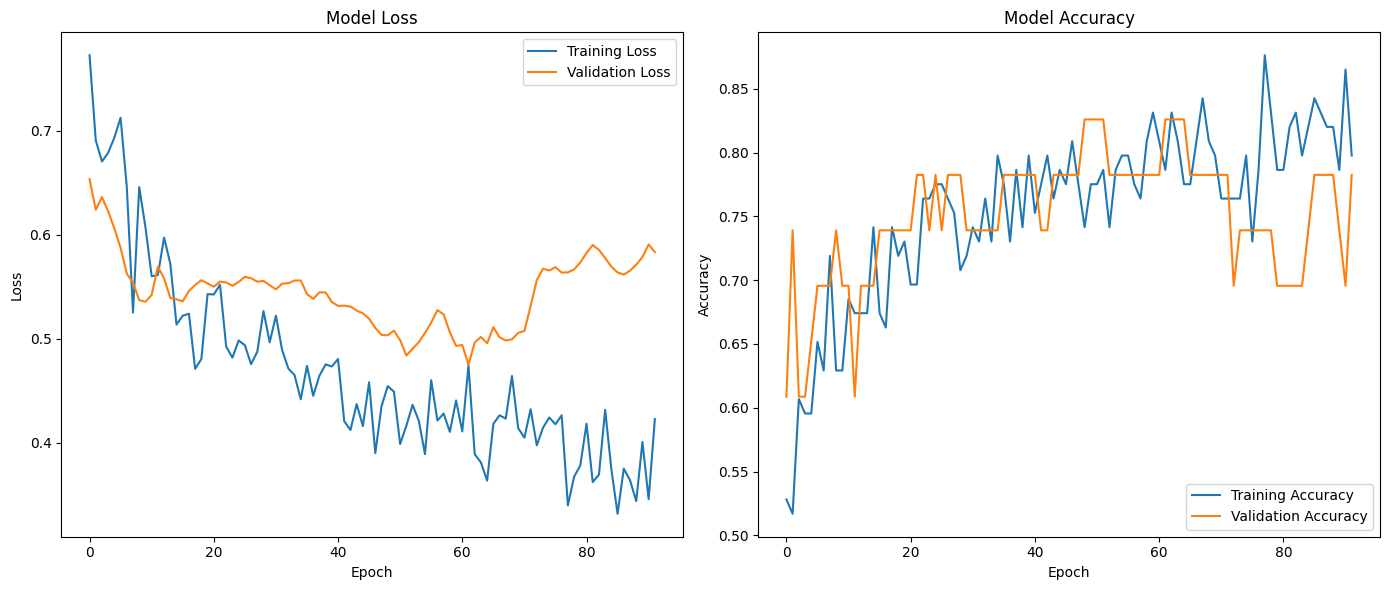

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


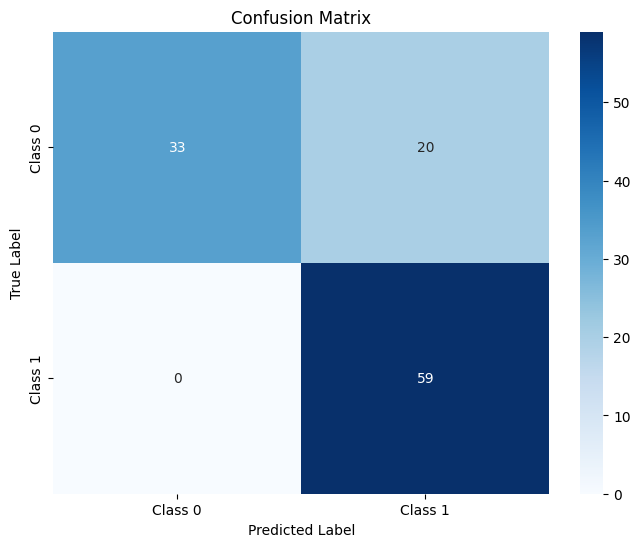

Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      0.62      0.77        53
     Class 1       0.75      1.00      0.86        59

    accuracy                           0.82       112
   macro avg       0.87      0.81      0.81       112
weighted avg       0.87      0.82      0.81       112



In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Plot training & validation loss values
def plot_training_validation_loss(history):
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    
    plt.tight_layout()
    plt.show()

# Generating confusion matrix and classification report
def generate_confusion_matrix_classification_report(model, x_train, y_train):
    y_pred = model.predict(x_train)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_train, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)
    cr = classification_report(y_true, y_pred_classes, target_names=['Class 0', 'Class 1'])

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print("Classification Report:\n", cr)

# Use the following lines after training your model
# Plot the training and validation loss/accuracy
plot_training_validation_loss(history_stacked)

# Generate confusion matrix and classification report
generate_confusion_matrix_classification_report(cnn_lstm_model, stacked_maps, labels_stacked)


In [44]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
def visualize_model_architecture(model, file_path='/kaggle/working/model_architecture.png'):
    plot_model(
        model, 
        to_file=file_path, 
        show_shapes=True,  # Displays the input/output shapes
        show_layer_names=True,  # Displays the layer names
        expand_nested=False,  # Expand nested models if any
        dpi=100  # Image resolution
    )
    print(f"Model architecture saved to {file_path}")

# Call the function to save the architecture visualization
visualize_model_architecture(cnn_lstm_model)


Model architecture saved to /kaggle/working/model_architecture.png
